TFIM
固有エネルギー E_n と J' tfim_En_J'

In [2]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', 's', '^', 'v', 'D', '*', '+', 'x']
colors = [
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:brown",
    "tab:gray",
]
OUTDIR = Path("charts")
def save_fig(fig, stem: str):
    fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
    print(f"saved: {OUTDIR / (stem + '.pdf')}")

# データ保存
DATADIR = Path("data")

# データ読み込み例
# fname = DATADIR / "square_sa_tcut.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

In [3]:
# ========= キャッシュ付きヘルパ =========
@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = [0.5 * M for M in (qt.sigmax(), qt.sigmaz())]
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites


def simulate(N, J, Jp, hx):
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    H_full = -Jp * Hcut_unit - J * Hex_rest_unit - hx * Hhx_unit
    E_n, psi_n = H_full.eigenstates(sparse=True)
    return np.real_if_close(E_n), psi_n

N is 6
⚠ Discord 通知に失敗: HTTPSConnectionPool(host='discord.com', port=443): Max retries exceeded with url: /api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x11a682990>, 'Connection to discord.com timed out. (connect timeout=5)'))
saved: charts/tfim_en_jp_N6_hx0.067.pdf


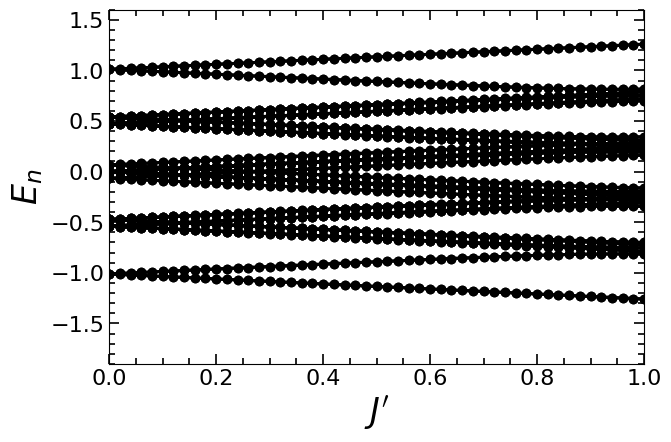

In [17]:
N_list = [6]
J = 1.0
Jp_list = np.linspace(1.0, 0.0, 51)
hx = 0.067

for i, N in enumerate(N_list):
    fig, ax = plt.subplots(figsize=(6.9, 4.6))
    inward_ticks(ax)
    results = [simulate(N=N, J=J, Jp=Jp, hx=hx) for Jp in Jp_list]
    En_list = np.stack([r[0] for r in results], axis=0)
    psin_list = np.stack([r[1] for r in results], axis=0)
    print(f"N is {N}")

    ax.plot(
        Jp_list,
        En_list,
        marker=markers[0],
        color=colors[0],
        markersize=6.0
    )

    ax.set_xlim(0.0, 1.0)
    ax.set_xlabel(r"$J'$", fontsize=24)
    ax.set_ylim(-1.9, 1.6)
    ax.set_ylabel(r"$E_n$", fontsize=24)

    # データ保存
    npz_path = DATADIR / f"tfim_en_jp_N{N}.npz"
    np.savez(
        npz_path,
        N =N,
        Jp_list=Jp_list,
        En_list=En_list,
        psin_list=psin_list
    )
    
    notify_discord(message=f"tifm sim 2 done")
    # グラフ保存
    save_fig(fig=fig, stem=f"tfim_en_jp_N{N}_hx{hx}")
    
    plt.show()